In this work, we will use existing trained model from [TensorFlow Hub](https://www.tensorflow.org/hub). One of the architecture is called MobileNet V2 which is a family of neural network architectures for efficient on-device image classification and related tasks, originally published by

Mark Sandler, Andrew Howard, Menglong Zhu, Andrey Zhmoginov, Liang-Chieh Chen: "Inverted Residuals and Linear Bottlenecks: Mobile Networks for Classification, Detection and Segmentation", 2018.

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.0,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [5]:
training_set

<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [6]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



In [7]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


This TF-Hub module uses the TF-Slim implementation of mobilenet_v2 with a depth multiplier of 1.0 and an input size of 224x224 pixels.

In [0]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

# if want to freeze the model to avoid the feature changes during training, the trainable parameter can set to false.
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3), trainable=False)

In [10]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 10

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
81/81 [==============================] - 10s 127ms/step - loss: 0.7643 - accuracy: 0.7151 - val_loss: 0.4543 - val_accuracy: 0.8456
Epoch 2/10
81/81 [==============================] - 9s 108ms/step - loss: 0.3747 - accuracy: 0.8778 - val_loss: 0.3569 - val_accuracy: 0.8783
Epoch 3/10
81/81 [==============================] - 9s 110ms/step - loss: 0.2952 - accuracy: 0.9027 - val_loss: 0.3318 - val_accuracy: 0.8874
Epoch 4/10
81/81 [==============================] - 9s 111ms/step - loss: 0.2502 - accuracy: 0.9253 - val_loss: 0.3103 - val_accuracy: 0.8910
Epoch 5/10
81/81 [==============================] - 9s 108ms/step - loss: 0.2132 - accuracy: 0.9373 - val_loss: 0.2996 - val_accuracy: 0.8955
Epoch 6/10
81/81 [==============================] - 9s 109ms/step - loss: 0.1857 - accuracy: 0.9525 - val_loss: 0.2827 - val_accuracy: 0.9010
Epoch 7/10
81/81 [==============================] - 9s 110ms/step - loss: 0.1679 - accuracy: 0.9568 - val_loss: 0.2840 - val_accuracy: 0.9010
Epoch

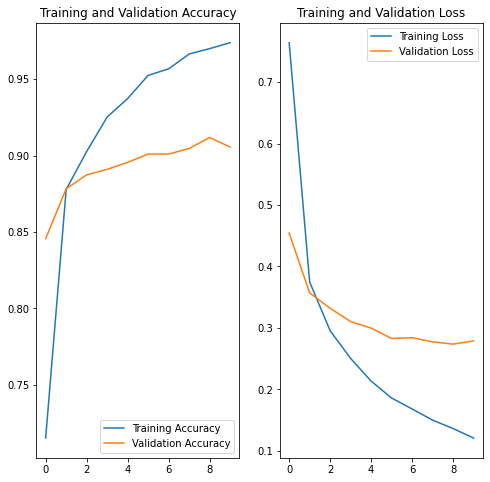

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
class_names = np.array(dataset_info.features['label'].names)

print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [14]:
image_batch, label_batch = next(iter(train_batches))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['dandelion' 'daisy' 'roses' 'roses' 'sunflowers' 'daisy' 'dandelion'
 'roses' 'roses' 'roses' 'roses' 'dandelion' 'roses' 'roses' 'sunflowers'
 'roses' 'sunflowers' 'daisy' 'dandelion' 'roses' 'roses' 'roses' 'roses'
 'sunflowers' 'daisy' 'dandelion' 'dandelion' 'dandelion' 'tulips'
 'dandelion' 'sunflowers' 'dandelion']


In [15]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [0 1 4 4 3 1 0 4 4 4 4 0 4 4 3 4 3 1 0 4 4 4 4 3 1 0 0 0 2 0 3 0]
Predicted labels:  [0 1 4 4 3 1 0 4 4 4 4 0 4 4 3 4 3 1 0 4 4 4 4 3 1 0 0 0 2 0 3 0]


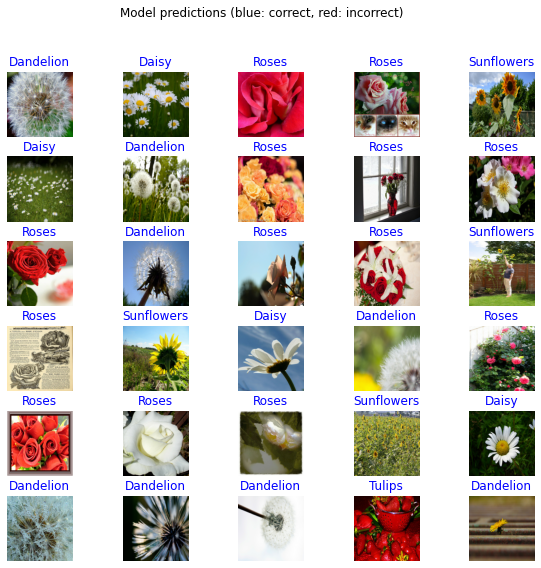

In [16]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

Seem like above sample predictions are correct!

# **Inception Model**

Next, we can try using Inception Model which is anothe pre-trained model from TensorFlow Hub. Inception takes as input images with dimension 299 x 299 pixels.

In [17]:
IMAGE_RES = 299

(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:70%]', 'train[70%:]'],
)
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMAGE_RES, IMAGE_RES, 3),
  trainable=False)

model_inception = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])

model_inception.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [18]:
model_inception.compile(
  optimizer='adam', 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 10

history = model_inception.fit(train_batches,epochs=EPOCHS,validation_data=validation_batches)

Epoch 1/10
81/81 [==============================] - 35s 434ms/step - loss: 0.7506 - accuracy: 0.7275 - val_loss: 0.4523 - val_accuracy: 0.8538
Epoch 2/10
81/81 [==============================] - 32s 401ms/step - loss: 0.3941 - accuracy: 0.8723 - val_loss: 0.3730 - val_accuracy: 0.8719
Epoch 3/10
81/81 [==============================] - 32s 400ms/step - loss: 0.3076 - accuracy: 0.9027 - val_loss: 0.3337 - val_accuracy: 0.8883
Epoch 4/10
81/81 [==============================] - 32s 401ms/step - loss: 0.2638 - accuracy: 0.9237 - val_loss: 0.3004 - val_accuracy: 0.8955
Epoch 5/10
81/81 [==============================] - 33s 403ms/step - loss: 0.2381 - accuracy: 0.9202 - val_loss: 0.2831 - val_accuracy: 0.8955
Epoch 6/10
81/81 [==============================] - 33s 404ms/step - loss: 0.2070 - accuracy: 0.9389 - val_loss: 0.2762 - val_accuracy: 0.8965
Epoch 7/10
81/81 [==============================] - 33s 402ms/step - loss: 0.1846 - accuracy: 0.9475 - val_loss: 0.2794 - val_accuracy: 0.9010

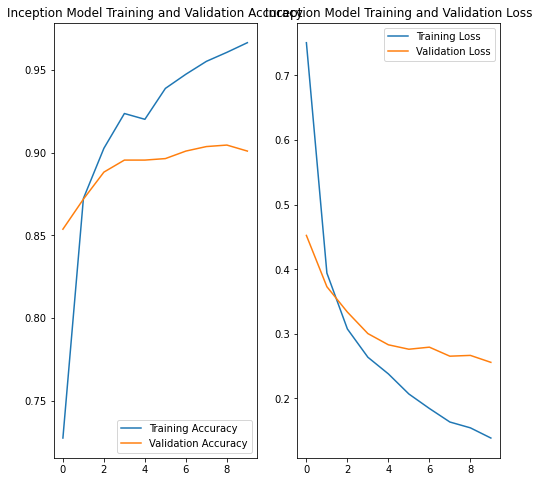

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Inception Model Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Inception Model Training and Validation Loss')
plt.show()